In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seawater as sw #import gsw
from tqdm import tqdm

In [1]:
# location of input data
data_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS104' 
data_resolution = '1d'

# location of mask data
mask_path = data_path
mesh_mask_filename = '1_mesh_mask_iMirabilis.nc'

# names of files to load
fname_T = f'1_{experiment_name}_{data_resolution}_2009*_grid_T_iMirabilis.nc'

In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:8787/status,
Dashboard: http://134.245.3.15:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:34015,Workers: 4
Dashboard: http://134.245.3.15:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.15:42373,Total threads: 2
Dashboard: http://134.245.3.15:34253/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:33801,


In [3]:
T = xr.open_mfdataset(data_path+experiment_name+'/'+fname_T)

# Density

In [17]:
%%time

#limit to area around Ewing (if only one location is chosen, the calculation in wayyyyy faster)
sliced = T.isel(x=slice(162,171),y=slice(293,298),deptht=slice(0,12)).compute()#.where((T.nav_lat < -23.1) & (T.nav_lat > -23.35) & (T.nav_lon > 8.15) & (T.nav_lon < 8.5) & (T.deptht<200), drop = True).compute()

CPU times: user 0 ns, sys: 14.4 s, total: 14.4 s
Wall time: 16.2 s


In [18]:
sliced

<xarray.Dataset>
Dimensions:               (y: 5, x: 9, deptht: 12, axis_nbounds: 2,
                           time_counter: 365)
Coordinates:
    nav_lat               (y, x) float32 -23.33 -23.33 -23.33 ... -23.14 -23.14
    nav_lon               (y, x) float32 8.1 8.15 8.2 8.25 ... 8.35 8.4 8.45 8.5
  * deptht                (deptht) float32 3.047 9.454 16.36 ... 112.3 134.3
    time_centered         (time_counter) datetime64[ns] 2009-01-01T12:00:00 ....
  * time_counter          (time_counter) datetime64[ns] 2009-01-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 0.0 6.194 ... 146.7
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 2009-01...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 2009-01...
    sossheig              (time_counter, y, x) float32 1.132 1.133 ... 1.142
    votemper              (time_counter, deptht, y, x) float32 21.0 ... 14.5
    vosaline              (time_counter, deptht, y, x) float32 35.73 ... 35.26
Attributes:
    name:         ./OUTPUT/1_INALT20.L46-KFS104_1d_20090101_20091231_grid_T_i...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-29 22:28:42 GMT
    uuid:         665455ea-d7db-418b-9c50-5474778b4701

In [19]:
# expand depth levels for INALT
expand_depth = xr.DataArray(np.zeros((12,5,9)))
expand_depth[:,:,:]=sliced.deptht.values[:,np.newaxis,np.newaxis]

In [20]:
%%time

# EOS80 density https://pythonhosted.org/seawater/eos80.html

sigma = xr.DataArray(sw.pden(sliced.vosaline,
                             sliced.votemper,
                             expand_depth,
                            )-1000, dims=('time_counter', 'deptht','lon','lat')).compute()
sigma = sigma.assign_coords(time_counter=sliced.time_counter, deptht=sliced.deptht.to_numpy())

CPU times: user 31.4 ms, sys: 12.7 ms, total: 44.1 ms
Wall time: 84.5 ms


In [22]:
%%time

# determine mixed layer depths...
MLD_INALT_s = []

for i in tqdm(range(365),desc="days"):#np.arange(1): #...for each day
    MLD_INALT_step = [] #empty lists for daily values
    for j in np.arange(len(sigma.lon)): #...each lon...
        for k in np.arange(len(sigma.lat)): #...and each lat around Ewing
            sigma.isel(time_counter=i, lon=j, lat=k).plot() #plot density
            threshold1_s = sigma.isel(time_counter=i, lon=j, lat=k).sel(deptht = 10, method = 'nearest')+.01 #get density threshold (10m density +.1 dsigma)
            lines = plt.gca().get_lines() #get lines of plot
            x_data1 = lines[0].get_xdata() #...
            y_data1 = lines[0].get_ydata() #...
            intersec_INALT = None
            for l in range(len(x_data1)): #determine intersec with threshold
                if y_data1[l] > threshold1_s and intersec_INALT is None:
                    intersec_INALT = x_data1[l]
            MLD_INALT_step.append(intersec_INALT) #append MLD for each location around Ewing at a day
            plt.close()
    MLD_INALT_s.append(np.mean(MLD_INALT_step)) #append mean for each day --> list with a value for each day

days: 100%|███████████████████████████████████| 365/365 [05:19<00:00,  1.14it/s]

CPU times: user 5min 12s, sys: 6.63 s, total: 5min 18s
Wall time: 5min 19s


In [23]:
data = {'INALT': MLD_INALT_s}
MLD_tides = pd.DataFrame(data,index=pd.date_range(start='2009-01-01', end='2009-12-31'))

In [24]:
MLD_tides.to_csv(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80-tides.csv')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


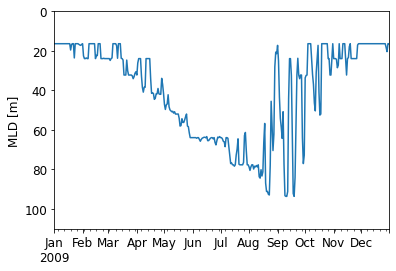

In [26]:
#monthly_means_s = MLD_s.resample('M').mean()
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'

MLD_tides['INALT'].plot(color='tab:blue')
#MLD_Franziska_sliced.squeeze().to_pandas().plot(color='tab:blue',linestyle='--') #.resample(time_counter='1M').mean()
#plt.xticks(monthly_means_s.index,['Jan\n2009','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('MLD [m]')
plt.ylim([0,110])
plt.gca().invert_yaxis();